# Practical 5. Detecting selective sweeps in population genomic data

At the end of this practical you should:

- Understand how positive selection acts to favor a beneficial mutation  
- Understand the role of drift/randomness on allele frequency trajectories and fixation probability
- Understand the effect of positive selection on linked neutral variation
- Understand how sweepfinder works using simulation data
- Be able to perform a Selective sweep scan on real data

In [2]:
import allel
import msprime
import tskit
import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
#jupyter magic
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 5.1 The direct effect of selection on a new mutation

We have so far considered the ancestry of samples backwards in time, and, in practical 2, have writen a simple coalescence time simulator in python. In this practical, we study the effect of positive selection on a focal *de novo* mutation. It is easiest to first think about the allele frequency trajectory of a new mutation forwards in time. 

Let's start by implementing a simple forwards in time simulation for the frequency trajectory of a new mutation under the neutral Wright Fisher (WF) model. We can then update this code to model positive selection acting on the new allele, and compare the dynamics of neutral and beneficial alleles.

### 5.1.1 Simulating drift fowards in time 

<div class="alert alert-block alert-info">
    <b>PopGen: Neutral Wright Fisher model</b> 
    
You should already be familiar with the neutral WF model (see Peter's population genetics lectures and PGA lecture 5). Consider a haploid population of $N_e$ individuals reproducing according to the WF model. We want to simulate the frequency trajectory of a *de novo* neutral mutation that appears in an individual.

In this model, each individual contributes on-average one offspring to the next generation. However, there is variance in offspring number: some individuals have 2, 3, or more children. And many will have no offspring at all.

From a coalescent perspective, we can think of this as each individual giving birth at the same _rate_, $1$. The next generation is formed by randomly assigning a parent to each offspring with probability $p = 1/N_e$, i.e. the rate of birth of the focal individual $1$ relative to the total birth rate in the population $N_e$.

Therefore, the frequency $k$ of the new mutation in the next generation, i.e. the probability that the focal individual has $k$ offspring, can be obtained simply by binomial sampling with "success probability" $p = 1/N_e$. 

$$P[k] = \binom{N_e}{k} p^k ( 1- p)^{N_e - k}$$

Furthermore, when $X$ individuals currently carry the new mutation, mutant individuals give birth with a total rate $X$. The probability of observing $k$ offspring is still binomially distributed but with $p=\frac{X}{N_e}$.  

By repeatedly drawing a random number of offspring and updating the probability $p$ of inheriting the new mutation, we can simulate the frequency trajectory of this mutation from generation to generation until it is eventually lost or fixed by drift.
    </div>

<div class="alert alert-block alert-warning">
    <b>Python recipe: <code>while</code> loops </b>

We want to track the frequency trajectory of a new neutral mutation forwards in time, stopping the simulation when the mutation is lost or fixed. 

To do this, we will use <code>while</code> loop.  You've already used <code>for</code> loops to iterate over arrays, e.g.<code>range(0,10)</code>. This loop stops once the end of the array is reached. A <code>while</code> loop, on the other hand, repeats until a particular condition is met. This is useful when we don't know beforehand how many iterations are needed to get the desired result.
    
Here's a <code>while</code> loop that generates a sequence of 20 random integers drawn uniformly from (0, 1, ... 9). In each iteration of the loop, the sequence gets longer, so we can use the <b>condition</b> <code> len(seq)&lt;20 </code> to stop the loop. 

E.g., when <code>len(seq)=17</code>, <code>len(seq)&lt;20 </code> evaluates as <code>True</code>. When <code> len(seq)=20</code>, the condition evaluates as <code>False</code> and the loop stops.
    </div>

In [3]:
seq = []
while len(seq)<20:
    a = np.random.randint(0,10)
    seq.append(a)
print(seq)

[3, 9, 8, 4, 2, 8, 9, 5, 6, 4, 6, 7, 1, 2, 5, 3, 1, 6, 3, 8]


<div class="alert alert-block alert-warning">
When there are multiple conditions that can stop the loop, it is often easier to write them within the loop itself. To do this we use <code>while True:</code> (meaning always proceed) and use <code>if</code> statements to define the conditions under which we halt the loop by calling <code>break</code>.

Below, we generate a sequence of 20 random numbers drawn randomly from (0,1,...,9), but here we stop adding values to the sequence if a "5" is drawn.
    </div>

In [4]:
seq = []
while True:
    a = np.random.randint(0,10)
    seq.append(a)
    if len(seq)>= 20:  ## the same condition as above, stop if seq length is 20, writing inequality the other way##
        break
    if a==5:  ## an additional condition to stop adding values when a '5' is drawn
        break
print(seq)

[0, 6, 4, 9, 5]


<div class="alert alert-block alert-warning"> <b>Warning!</b> This type of loop can be dangerous. If a stop condition can't be met, the computer will run forever, and it is a good idea to define a limit to the number of iterations, just in case.
        </div>

Now that we know how to use a `while` loop, we can implement the neutral WF simulation as a function:

In [7]:
def sim_neutral(i,Ne): 
    # i is any unique ID for the simulation. is converted to string. Usually pass an integer. 
    # N_e is the (haploid) population size 
    
    maxGens = 4000 #largest number of generations we will simulate.
    bCount = Ne -1 #initial freq of ancestral allele
    BCount = 1 #initial freq of new mutation  
    traj = [] # will be populated by the frequency trajectory of neutral mutation. 
    
    while True: #starts the simulation
        
        traj.append(BCount) #append current frequency to trajectory
        
        
        if(BCount >= Ne):
            break
        if(BCount <= 0):
            break
        if(len(traj)>maxGens): 
            break
        
        
        ### sample to make the next generation ###
        
        pB = (BCount*(1))/(BCount*(1)+ bCount*(1)) #prob of sampling the focal allele
        
        BCount = np.random.binomial(Ne,pB)  # random number of derived mutations drawn 
                                            # from binomial distribution to produce next generations 
        bCount = Ne - BCount 
        
    # create and return a pandas data frame for the replicate smulation 
    gens = list(range(len(traj)))
    sim = [str(i) for _ in range(len(traj))]
    df = pd.DataFrame({"sim":sim,"gens":gens,"freq":traj})
    return(df)    

sim_neutral(1,10)

,sim,gens,freq
0,1,0,1
1,1,1,1
2,1,2,2
3,1,3,3
4,1,4,1
5,1,5,1
6,1,6,2
7,1,7,2
8,1,8,3
9,1,9,4


<div class="alert alert-block alert-success">    
    <b>Exercise 1:</b> In the code above, what are the three conditions that stop the <code>while</code> loop and what do they mean in the context of simulating the allele frequency trajectory?

SOL:

       if(BCount >= Ne): #if fixed, stop
            
        if(BCount <= 0):  #if lost, stop
            
        if(len(traj)>maxGens): # stop after maxGens if mutation is still segregating 

The wrapper function below returns a single data frame that combines data across replicate simulations. We can then use `sns.relplot` to plot the trajectories and distinguish replicates by their unique IDs.

In [8]:
def get_neutral_replicates(num_reps,Ne):
    replicates = [sim_neutral(i,Ne) for i in range(num_reps)]
    trajectories = pd.concat(replicates,ignore_index=True)
    return(trajectories)

get_neutral_replicates(num_reps=3,Ne=10)

,sim,gens,freq
0,0,0,1
1,0,1,0
2,1,0,1
3,1,1,1
4,1,2,1
5,1,3,0
6,2,0,1
7,2,1,0


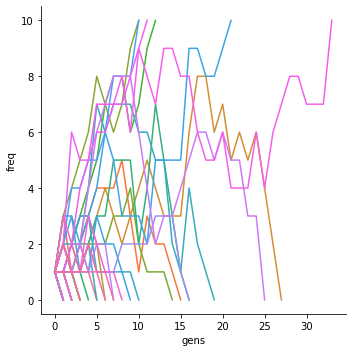

In [9]:
neu_trajectories= get_neutral_replicates(num_reps=50,Ne=10)
sns.relplot(x = "gens", y = "freq",hue="sim",kind = "line",data = neu_trajectories,legend=False)
plt.show()

### 5.1.2 Simulating selection **AND** drift

<div class="alert alert-block alert-info">
    <b>PopGen:</b> 

Suppose now that the *de novo* mutation confers a fitness advantage of $s$. In the WF model, carriers of the beneficial mutation leave on average a greater number of offspring, that is, reproduce at rate $(1 + s)$, while the remaining $N_e - 1$ individuals carrying the ancestral allele still give birth at rate $1$. The probability that any offspring inherits the new beneficial mutation is still binomially distributed, but now  $p = \frac{(1)(1 + s)}{(1)(1+s) + (N_e - 1)(1)}$. 

As for the neutral case above, when there are $ X > 1$ copies of the beneficial mutation, the probability observing $k$ copies in the next generation is binomially distributed with $p= \frac{X(1 + s)}{X(1 + s) + ( N_e  - X)( 1)}$.
    </div>

<div class="alert alert-block alert-success">    
    <b>Exercise 2:</b>
 <ul>
    <li> copy the code for running the neutral simulation below and modify it to include positive selection for simulating the frequency trajectory of a new beneficial mutation. The new function <code>sim_selection(i,Ne,s)</code> will take a third parameter for the strength of selection. </li>
        <li>check that it returns a data frame with the same formatting as above.</li>
        <li>once your selection simulations work, use the wrapper function <code>get_selection_replicates()</code> below to run 50 replicate simulations.</li>
        <li> plot the results.</li>
      </ul>
    </div>

In [ ]:
## complete this function using the neutral simulation code to include positive selection in the simulation ##
def sim_selection(i,Ne,s):
    # i is any unique ID for the simulation. is converted to string. Usually pass an integer. 
    # N_e is the (haploid) population size 
    # s is is selection coefficient
    

sim_selection(i=1,Ne=50,s=0.1)

In [10]:
#SOL
def sim_selection(i,Ne,s):
    # i is any unique ID for the simulation. is converted to string. Usually pass an integer. 
    # N_e is the (haploid) population size 
    # s is is selection coefficient
    maxGens = 4000 #largest number of generations we will simulate
    
    bCount = Ne -1 #initial number of background allele
    BCount = 1 #initial freq of new beneficial mutation  
    traj = [] # will be populated by the frequency trajectory of ben mutation. 
    
    while True: #starts the simulation
        traj.append(BCount) #append current frequency to trajectory
        if(BCount >= Ne): 
            break
        if(BCount <= 0):  
            break
        if(len(traj)>maxGens):
            break
        
        # otherwise, we sample to make next generations
        pB = (BCount*(1 + s))/(BCount*(1 + s)+ bCount*(1)) #prob of sampling ben allele
        BCount = np.random.binomial(Ne,pB) # random number of ben mutations drawn 
                                            #from binomial distribution to produce next generations 
        bCount = Ne - BCount 
        
    # create and return a pandas data frame for the replicate smulation 
    gens = list(range(len(traj)))
    sim = [str(i) for _ in range(len(traj))]
    df = pd.DataFrame({"sim":sim,"gens":gens,"freq":traj})
    return(df)    

sim_selection(i=1,Ne=50,s=0.1)

,sim,gens,freq
0,1,0,1
1,1,1,0


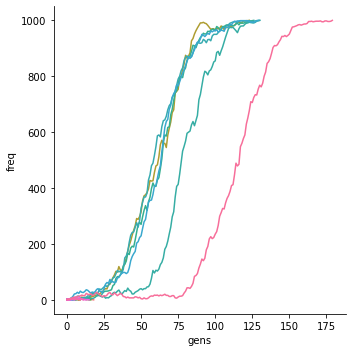

In [11]:
def get_selection_replicates(num_reps,Ne,sb):
    replicates = [sim_selection(i,Ne,sb) for i in range(num_reps)]
    trajectories = pd.concat(replicates,ignore_index=True)
    return(trajectories)

sel_trajectories= get_selection_replicates(num_reps=50,Ne=1000,sb=0.1)
sns.relplot(x = "gens", y = "freq",hue="sim",kind = "line",data = sel_trajectories,legend=False)
plt.show()

### 5.1.3 The effect of population size and selection strength on trajectories

Using the selection simulations you have implemented above, we can compare the fate of new mutations for different population sizes and strengths of selection. For each parameter combination, we plot 200 replicate trajectories of the new mutation.

We plot neutral simulations (first column) weak selection simulations (second column) and strong selection simulations (third column). Each row corresponds to a different population size (100, 1000, 10000), increasing from top to bottom.

For the selection scenarios, we also plot the expected deterministic allele frequency trajectory for a beneficial mutation (see lecture 5) using the function <code>calc_expected_traj</code> defined below:

In [13]:
def calc_expected_traj(Ne,sb):
    gensTotal = 10*Ne
    pB = 1
    traj = []
    for t in range(gensTotal):
        thisPB =  pB*math.exp(sb*t)/((pB*math.exp(sb*t) + Ne - 1))
        traj.append(thisPB)
        if thisPB >= (Ne-1)/(Ne):
            traj = np.array(traj)
            traj = traj*(Ne)
            return(traj)
            break
    traj = np.array(traj)
    traj = traj*(Ne)
    return(traj)

calc_expected_traj(10,0.2)

array([1.        , 1.19494632, 1.42189251, 1.68369876, 1.98256899,
       2.31969317, 2.69487452, 3.10619522, 3.54978923, 4.01979347,
       4.5085306 , 5.00693855, 5.50520865, 5.99354302, 6.46291022,
       6.90567858, 7.3160391 , 7.69018148, 8.02623937, 8.32405931,
       8.5848645 , 8.81088172, 9.00498468])

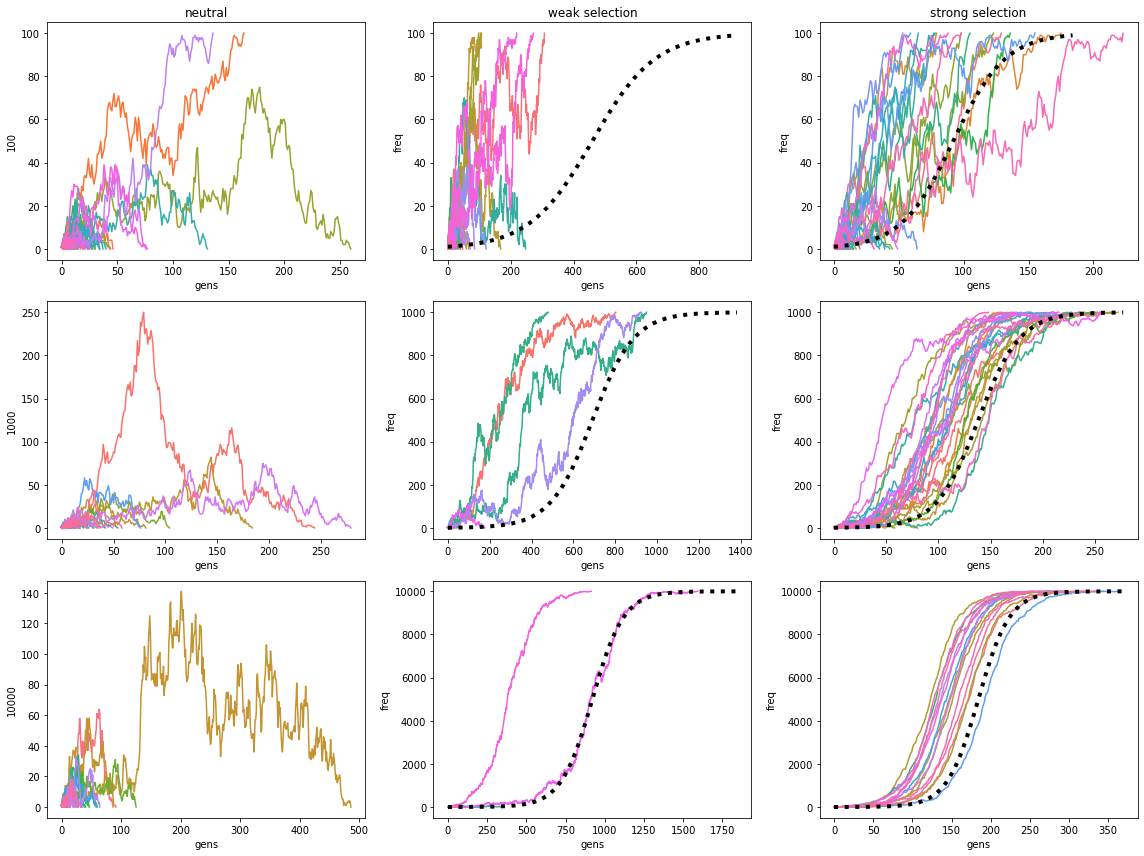

In [14]:
pop_sizes = [100,1000,10000]
sel_strengths = [0.01,0.05]
num_reps = 200

fig, axs = plt.subplots(3,3,figsize=(16,12))

for rowidx, Ne in enumerate(pop_sizes):
    trajectories = get_neutral_replicates(num_reps,Ne)
    sns.lineplot(x = "gens", y = "freq",hue="sim",data = trajectories,legend=False,ax = axs[rowidx,0])

for rowidx, Ne in enumerate(pop_sizes):
    for colidx,sb in enumerate(sel_strengths):
        trajectories = get_selection_replicates(num_reps,Ne,sb)
        sns.lineplot(x = "gens", y = "freq",hue="sim",data = trajectories,legend=False,ax = axs[rowidx,colidx +1])
        axs[rowidx,colidx+1].plot(calc_expected_traj(Ne,sb),":k",linewidth=4.0)
        
axs[0,0].set_title("neutral")
axs[0,1].set_title("weak selection")
axs[0,2].set_title("strong selection")

for ax,size in list(zip(axs[:,0],pop_sizes)):
    ax.set_ylabel(size)


fig.tight_layout()
plt.show()

<div class="alert alert-block alert-success">    
    <b>Exercise 3:</b> Execute the code cell above! 
     <ul>
    <li> How do trajectories differ for neutral vs. weak vs strong selection? How does this depend on pop size?</li> 
    <li> What is the fate of most new mutations, and why? Write down your conclusions?</li> 
    </ul
         
         
<b>Note:</b> the different scale of the x-axis (number of generations) in each plot.
    </div>

SOLUTION:
- across all scenarios, the new mutation tends to go extinct. Prob fix expected 1/(2Ne)
- a beneficial allele has a higher chance of reaching fixation, and this increases with the strength of selection (expected approximately $2 s_b$ in sufficiently large population)
- in small population, the trajectories of successful beneficial mutations are more variable
- in large populations, replicates that go to fixation vary in the total time to reach fixation but otherwise have similar shape as the deterministic model
- The ben allele reaches fixation much faster with stronger selection



<div class="alert alert-block alert-success">    
    <b>Class discussion:</b> 
    <ul>
    <li> How do trajectories differ when the allele frequency is low vs high? What dynamics of the model can explain these patterns?</li> 
    <li> How do sim trajectories differ from the expectation (dashed line above) and why?</li> 
        </ul>
    </div>

SOL: when the allele is very rare or very common, the frequency changes slowly, but at intermediate frequency, it goes quickly: the change in allele frequency $p$ is expected to be $p(1-p)s$.

SOL: the simulation trajectories reach high intermediate frequency and eventually fix more quickly than expected, but the shape of the trajectories at intermediate frequency matches expectation. The expected trajectory averages over all possible allele frequency changes, i.e. over all possible trajectories, including those in which the ben mutation is lost. However, the beneficial mutations which are lucky enough to reach fixation will tend to be those which by-chance get to high frequency quickly. Once at intermediate frequency, the allele is almost certain to fix, and the expected trajectory captures the dynamics of the underlying model accurately.

# 5.2 The effect of selection on linked neutral sites

Now that we have studied the direct effects of selection on the evolutionary trajectory of a new beneficial mutation, we want to investigate how fixation of an adaptive allele affects linked neutral sites in the genome.

Here we will use simulations in `msprime` to investigate the effect of positive selection on linked neutral variants.

### 5.2.0 Neutral Simulations


<div class="alert alert-block alert-warning">
    <b>Python refresher: simulating under the coalescent with <code>msprime</code> </b>  

Below, we simulate 50Mb of sequence assuming $N_e = 10,000$ (see <i>Homo</i> like sims in practical 3) under the standard neutral coalescent and plot the total branch length for each tree along the sequence.

In [4]:
#This specifies parameters
Ne = 10_000
L = 50e6
rbp = 2e-9
n=20
sb=0.05
seed_sel=12345
seed_neu=54321
#We are specifying a mutation rate, but will use branch-based statistics as much as possible (for efficiency):
mu = 1e-8 
#We are setting up an empty data frame which we will fill as we go along:
divdf = pd.DataFrame() 

In [5]:
#This sets up a single neutral simulation given the parameters above: 
ts_neutral = msprime.sim_ancestry(
    samples=n,
    model=[msprime.StandardCoalescent()],
    population_size=Ne,
    recombination_rate=rbp,
    sequence_length=L,
    random_seed=seed_neu
)

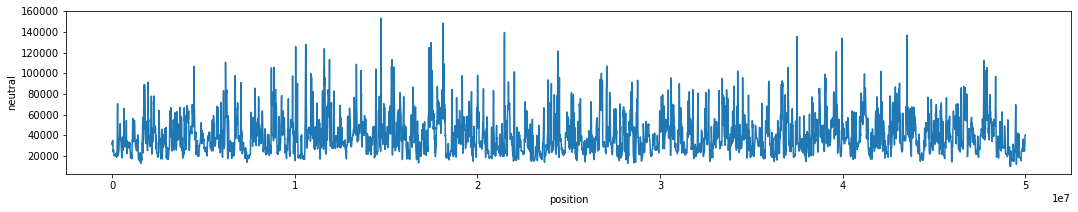

In [6]:
#Making windows of 10kb 
winStartPositions = np.arange(0,L,10_000)
slidingWindows=np.append(winStartPositions,L)

divdf["position"]=winStartPositions
#computing diversity in windows
div_neu = ts_neutral.diversity(windows=slidingWindows, mode='branch')
divdf["neutral"]=div_neu

fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(data =divdf, x="position",y="neutral")
plt.show()

### 5.2.1 The effect of selection on genetic diversity

<div class="alert alert-block alert-success">    
    <b>Exercise 4 - msprime simulation for positive selection:</b> Modify the code below to implement a sweep model. Calculate diversity in windows, add this to the data frame "divdf" as a new column called "sweep", and produce a scatter plot (as above). For the sweep model: Place the beneficial mutation at the center of the chromosome. For the initial frequency, assume that the beneficial allele is a <i>de novo</i> mutation. For the final frequency, stop the sweep when there is only one copy of the ancestral mutation remaining.
    
<b>Hints: </b> Check out the msprime documentation of [<code>SweepGenicSelection</code>](https://tskit.dev/msprime/docs/latest/api.html#msprime.SweepGenicSelection) to:
<ul>
    <li> Define a positive selection model placing the beneficial mutation at the center of the chromosome.</li> 
    <li> Combine the selection phase with a neutral coalescent to simulate selective sweep.</li>
    <li> Compute and plot genetic diversity in sliding windows as before.</li>
    </ul>
    </div>

In [7]:
## Insert parameter values for the position, start and end frequency in the code below to define the 
# sweep model.
sweepModel = msprime.SweepGenicSelection(
    position = L/2, 
    #ben mutation at the centre
    start_frequency=1/(2*Ne), #initial freq of de-novo mutation
    end_frequency= 1 - 1/(2*Ne), #final frequency of de-novo ben mutation
    s=sb,
    dt = 1/(40*Ne)
)

In [14]:
## define the correct model below
ts_sel = msprime.sim_ancestry(
    samples=n,
    model=[sweepModel,msprime.StandardCoalescent()], #simulate the sweep first, followed by standard coal
    population_size=Ne,
    recombination_rate=rbp,
    sequence_length=L,
    random_seed=seed_sel
)
print(ts_sel.num_trees)

13654


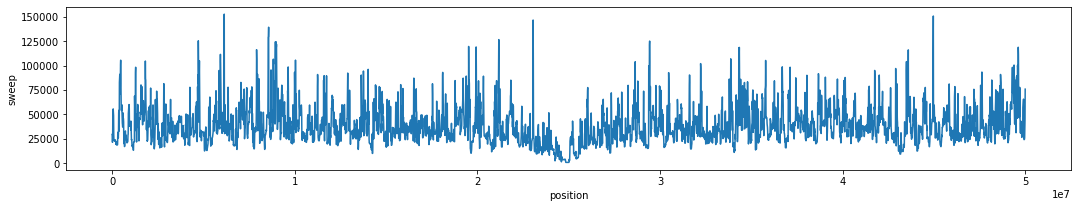

In [15]:
#SOL
div_sel = ts_sel.diversity(windows=slidingWindows,mode='branch')
divdf["sweep"] = div_sel

fig, ax = plt.subplots(figsize=(18,3))
sns.lineplot(data =divdf, x="position",y="sweep")
plt.show()


<div class="alert alert-block alert-success">    
    <b>Exercise 5:</b> How does selection affect the distribution of window-wise genetic diversity compared to the neutral distribution?

<b> Hint:</b> Use <code>sns.histplot</code> to plot both distributions.
    </div>

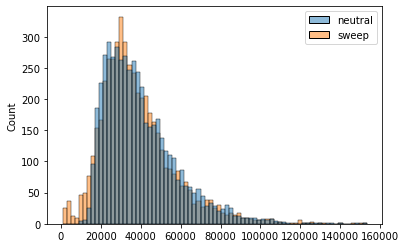

In [21]:
#SOLUTION:

p = sns.histplot(data=divdf[["neutral","sweep"]])

#increased number of low-diversity windows in sweep simulation

### 5.2.2 The effect of selective sweeps on the SFS

We will consider a smaller sample of $n=5$ (diploid) individuals, a shorter length of sequence (4Mb) to investigate the effect of sweeps on the SFS at nearby neutral sites. As in practical 2 we will compute the expected SFS by averaging across replicates (in this case 500).

In [22]:
popSize = 10_000
benStrength = 0.05
chrLength = 4e6
recRate = 1e-9
sampleSize = 5 #diploids
numReplicates = 500
numWindows=4
winBreaks = [chrLength/numWindows*i for i in range(0,numWindows+1)]

<div class="alert alert-block alert-info">
<b>PopGen reminder: the SFS</b>
    
You have already enountered the analytic predictions for the SFS for a sample from a neutral WF population in practical 2. Given a sequence with a scaled mutation rate $\theta$, the SFS (in terms of the expected number of iton mutations) is $S_i = \theta/i$ for $i = 1,2,...,n-1$. See lecture 2.
    </div>

The code chunk below obtains the expected neutral SFS for polarized `neutSFSUnfolded` and non-polarized data `neutSFSFolded` for a sample of $n$ individuals:

In [23]:
neutExp = np.array([1/i for i in range(1,2*sampleSize)])
neutSFSUnfolded = neutExp
neutSFSUnfolded /= neutSFSUnfolded.sum()

neutFlipped = np.flip(neutExp)
neutSFSFolded = neutExp + neutFlipped #sum them together for the 'folding'
neutSFSFolded = neutSFSFolded[0:sampleSize] # only look at the minor allele counts
neutSFSFolded[-1] = neutSFSFolded[-1]/2 # because we've counted the entry for this twice

<div class="alert alert-block alert-success">    
    <b>Exercise 6:</b> 
    <ul>
    <li>use the unfolded SFS (<code>neutSFSUnfolded</code>, above) to work out the frequency of singletons in the folded SFS.</li>
    <li>Does this agree with <code>neutSFSFolded</code> defined below?</li>
    </ul>
</div>

In [24]:
print(neutSFSUnfolded[0]+ neutSFSUnfolded[-1])
print("the unpolarized SFS is:\n", neutSFSFolded[0])

0.3927619581989059
the unpolarized SFS is:
 0.3927619581989059


Let's investigate the effect of sweeps on the SFS at linked neutral sites. The code chunk below runs 500 replicate sweep simulations, assuming a single beneficial allele at `position = 1`
- for each replicate, we get the (unfolded) SFS in 1Mb windows (non-overlapping) increasingly far from the center of the sweep.
- for each distance, we average the SFS across replicates.

In [25]:
sweepModel = msprime.SweepGenicSelection(
    position = 1,
    start_frequency=1.0/(2*popSize),
    end_frequency= 1 - 1.0/(2*popSize),
    s=benStrength,
    dt = 1/(40*popSize)
)

replicates = msprime.sim_ancestry(
    samples=sampleSize,
    model=[sweepModel,msprime.StandardCoalescent()],
    population_size=popSize,
    recombination_rate=recRate,
    sequence_length=chrLength,
    num_replicates = numReplicates,
    random_seed=8675309
)

sfs_rep_table = np.zeros((numReplicates,numWindows,2*sampleSize+1))
for replicate_index, ts in enumerate(replicates):
    sfs = ts.allele_frequency_spectrum(mode = "branch",polarised = False,windows=winBreaks)
    sfs_rep_table[replicate_index] = sfs

#win_sfs_table: each row is the SFS for a window of 1Mb increasingly far from the sweep centre.
win_sfs_table = np.apply_along_axis(np.mean,0,sfs_rep_table)
win_sfs_table = np.apply_along_axis(lambda x: x/sum(x),1,win_sfs_table)
win_sfs_table = np.apply_along_axis(lambda x: x[1:-1],1,win_sfs_table)
print(win_sfs_table)

[[0.6496404  0.20609197 0.0786013  0.04618821 0.01947812 0.
  0.         0.         0.        ]
 [0.54252807 0.22182565 0.11209111 0.08487567 0.0386795  0.
  0.         0.         0.        ]
 [0.47291102 0.22191098 0.14514665 0.11103539 0.04899596 0.
  0.         0.         0.        ]
 [0.42184846 0.22352031 0.15941475 0.13136388 0.0638526  0.
  0.         0.         0.        ]]


<div class="alert alert-block alert-success">    
    <b>Exercise 7:</b> Combine the results for the average SFS for the different distances from the sweep with the neutral expectation (both are defined as dataframes below) into a single dataframe and plot both using a braplot (see practical 2). How does selection affect the folded SFS and how does this depend on the distance from the beneficial mutation?
    </div>

In [26]:
iTons = list(range(1,10))
windows = ['first','second','third','fourth']
dfWST = pd.DataFrame()

for name,vals in list(zip(windows,win_sfs_table)):
# This creates a temporary dataframe for each distance from the sweep 
    tempdf = pd.DataFrame({'itons':iTons,'freq':vals,'window':[name]*(2*sampleSize-1)})
    dfWST= pd.concat([dfWST,tempdf])

nSFS = np.zeros(len(neutSFSUnfolded)) #add zero entries to unfolded SFS for plotting and store as "a"
for idx, val in enumerate(neutSFSFolded):
    nSFS[idx]=val
dfNeut = pd.DataFrame({'itons':iTons,'freq':nSFS,'window':['neutral']*(2*sampleSize-1)})

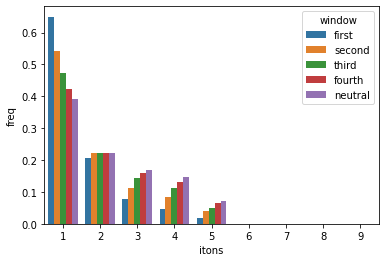

In [27]:
#SOL:
dfWST = pd.concat([dfWST,dfNeut])

p = sns.barplot(x="itons",y="freq",hue="window",data=dfWST)

# 5.3 Genomic scans for adaptive evolution using SweepFinder


Here we will perform scans for selection using SweepFinder on the `ts_neu` and `ts_sel` simulations obtained in **5.2.2** above (the ones with long chromosomes, $n=20$ and the beneficial mutation in the middle). Details of the method are found [Nielsen et al 2005](https://genome.cshlp.org/content/15/11/1566). We first learn to format the data correctly for use in SweepFinder and then think about how to interpret the results.

### 5.3.1 The neutral background SFS

we will use the expected neutral SFS for performing our scans, provided below, and formatted for use in SweepFinder:

In [28]:
bgSFS =np.array([0.        , 0.24112628, 0.12373586, 0.08472005, 0.06530504,
       0.05373671, 0.04609767, 0.04070963, 0.03673408, 0.03370582,
       0.03134642, 0.02947939, 0.02798787, 0.02679181, 0.02583496,
       0.02507713, 0.02448939, 0.02405096, 0.02374729, 0.02356873,
       0.01175491, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

iTon=list(range(0,2*n))
sweepfinder_bgsfs = np.array(list(zip(iTon,bgSFS)))
sweepfinder_bgsfs

array([[0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 2.4112628e-01],
       [2.0000000e+00, 1.2373586e-01],
       [3.0000000e+00, 8.4720050e-02],
       [4.0000000e+00, 6.5305040e-02],
       [5.0000000e+00, 5.3736710e-02],
       [6.0000000e+00, 4.6097670e-02],
       [7.0000000e+00, 4.0709630e-02],
       [8.0000000e+00, 3.6734080e-02],
       [9.0000000e+00, 3.3705820e-02],
       [1.0000000e+01, 3.1346420e-02],
       [1.1000000e+01, 2.9479390e-02],
       [1.2000000e+01, 2.7987870e-02],
       [1.3000000e+01, 2.6791810e-02],
       [1.4000000e+01, 2.5834960e-02],
       [1.5000000e+01, 2.5077130e-02],
       [1.6000000e+01, 2.4489390e-02],
       [1.7000000e+01, 2.4050960e-02],
       [1.8000000e+01, 2.3747290e-02],
       [1.9000000e+01, 2.3568730e-02],
       [2.0000000e+01, 1.1754910e-02],
       [2.1000000e+01, 0.0000000e+00],
       [2.2000000e+01, 0.0000000e+00],
       [2.3000000e+01, 0.0000000e+00],
       [2.4000000e+01, 0.0000000e+00],
       [2.5000000e+01, 0.

Note that the SFS has been normalised, i.e. sums to 1:

In [29]:
np.sum(bgSFS)

1.0

###  5.3.2 mutation counts

So far, we have used branch-based statistics provided by msprime/tskit. However, when running sweepfinder scans on population genomic data (simulated or real), we can only work with polymorphisms.

Below, we add mutations to the _neutral_ simulation, obtain mutation counts along the genome, and format this as an input table for SweepFinder.

In [31]:
mts_neutral = msprime.sim_mutations(ts_neutral, rate=mu,random_seed=6789)

print("theta per base= ", 4*Ne*mu)
print("observed num mutations:", mts_neutral.num_mutations)
#The expected SFS in terms of mutation counts
print("expected num mutations",mu*4*Ne*L* sum([1/i for i in range(1,2*n)])) 

biallelicSNPsNeutral = [[int(var.site.position), min([sum(var.genotypes),2*n - sum(var.genotypes)]),2*n,1] for var in mts_neutral.variants() if len(var.alleles)==2]
biallelicSNPsNeutral = pd.DataFrame(biallelicSNPsNeutral,columns=['position','x','n','folded'])

print("\n")
print("the first few entries of the mutation count file should look like:\n")
print(biallelicSNPsNeutral[0:10])

theta per base=  0.0004
observed num mutations: 84331
expected num mutations 85070.86077872751


the first few entries of the mutation count file should look like:

   position   x   n  folded
0      1180   3  40       1
1      2357  20  40       1
2      2922   5  40       1
3      3141   7  40       1
4      3206   2  40       1
5      4100  13  40       1
6      4470  13  40       1
7      5290   2  40       1
8      5510   1  40       1
9      5979   7  40       1


Here we obtain mutation counts for the _sweep_ simulation:

In [32]:
mts_sel = msprime.sim_mutations(ts_sel, rate=mu,random_seed=9876)

print("theta per base= ", 4*Ne*mu)
print("observed num mutations:", mts_sel.num_mutations)
print("expected num mutations",mu*4*Ne*L* sum([1/i for i in range(1,2*n)])) #expected number

biallelicSNPsSweep = [[int(var.site.position), min([sum(var.genotypes),2*n - sum(var.genotypes)]),2*n,1] for var in mts_sel.variants() if len(var.alleles)==2]
biallelicSNPsSweep = pd.DataFrame(biallelicSNPsSweep,columns=['position','x','n','folded'])

print("\n")
print("the first few entries of the mutation count file should look like:\n")
print(biallelicSNPsSweep[0:10])

#although we won't do it here, the the sweep sim mutation counts would be saved to a file using:
#biallelicSNPsSweep.to_csv('./sim_sweepfinder/folded_sweep_mut_counts.txt',sep='\t',header=True,index=False)

theta per base=  0.0004
observed num mutations: 81246
expected num mutations 85070.86077872751


the first few entries of the mutation count file should look like:

   position   x   n  folded
0      3013  17  40       1
1      3475   3  40       1
2      5138   7  40       1
3      5384   3  40       1
4      6012   1  40       1
5      6495  17  40       1
6      7333   7  40       1
7      7533   1  40       1
8      8972   3  40       1
9     10890   3  40       1


<div class="alert alert-block alert-success">    
    <b>Exercise 8:</b> Check the output above. How does the total number of mutations ($S$) differ between the neutral and the sweep simulation? How close are either to the analytic expectation $E[S]$ under neutrality?
    </div>

In [62]:
#SOL:
#- the observed number of mutations is lower than expected for the selective sweep simulations 
#- the hitchhiking of mutations at sites linked to the beneficial mutation results in fixation 
#- of one allele and loss of the other

<div class="alert alert-block alert-success">    
    <b>Python challenge (optional):</b> We used this line of code in the cell above. 
    
    
    [[int(var.site.position), min([sum(var.genotypes),2*n - sum(var.genotypes)]),2*n,1] for var in mts_neutral.variants() if len(var.alleles)==2]
    
    
Can you work out what is being calculated? Can you rewrite it using a <b>for</b> loop?

</div>

In [33]:
#SOL:
biallelicSNPsNeutral = [] #creates an empty list to store the variants
for var in mts_neutral.variants(): #iterates through the variable sites in the mutated neutral simulation
    if len(var.alleles)==2: # if the site is biallelic
        pos = int(var.site.position) #get the position
        minor=min([sum(var.genotypes),2*n - sum(var.genotypes)]) #get minor allele count
        samples = 2*n #get total number of samples included in this site (for real data, that means after filtering)
        fold = 1 # set value of 1 to indicate that the mutation counts at this site are folded
        
        biallelicSNPsNeutral.append([pos,minor,samples,fold]) #add this to the list of biallelic SNPs
    #otherwise, if site is note biallelic, move on to the next one

### 5.3.3 sweepfinder results

We have 'pre-baked' some SweepFinder runs on the two simulated data files generated above. Let's look at and interpret the results.

The scans were run using the following commands:

../SweeD_v3.2.1_Linux/SweeD -folded -name foldedtestNeu -input folded_neutral_mut_counts.txt -grid 10000 -isfs folded_sfs_file.txt

../SweeD_v3.2.1_Linux/SweeD -folded -name foldedtestSel -input folded_sweep_mut_counts.txt -grid 10000 -isfs folded_sfs_file.txt

Here we import the results files generated by the SweepFinder method and save each as a dataframe.

In [34]:
! wget https://www.dropbox.com/s/ul7bm5956mlx8gw/p5_data.tar.gz?dl=0 -q --show-progress -O p5_data.tar.gz
! tar zxf p5_data.tar.gz

p5_data.tar.gz      100%[===================>]  22.12M  5.02MB/s    in 10s     


In [35]:
! ls -lh p5_data/

total 23M
-rw-rw-r-- 1 derek derek  22M Nov 12  2021 heli_chrom18.vcf.gz
-rw-rw-r-- 1 derek derek 340K Jan 26  2022 SweeD_Report.foldedtestNeu
-rw-rw-r-- 1 derek derek 340K Jan 26  2022 SweeD_Report.foldedtestSel
-rw-rw-r-- 1 derek derek 336K Jan 21  2022 SweeD_Report.scanChr18


In [37]:
neutralScan= pd.read_csv("p5_data/SweeD_Report.foldedtestNeu",header=1,delimiter="\t")
selScan= pd.read_csv("p5_data/SweeD_Report.foldedtestSel",header=1,delimiter="\t")
neutralScan[0:5]

,Position,Likelihood,Alpha
0,1180,0.215882,31.636840
1,6180,0.012141,0.011956
2,11180,0.138340,0.009554
3,16180,0.021040,0.010186
4,21181,0.012325,0.014136


<div class="alert alert-block alert-info">
    <b>PopGen: Estimating $s$ from SweepFinder's $\alpha$ </b>
    
$\alpha$ is a measure of the rate of recombination relative to the effective strength of selection in the population.  $\alpha = r/s* Log( 2 N_e)$. If we have an estimate of $r$ and $N_e$ (or know them, as in these simulations) we can convert this estimate of $\alpha$ to an estimate of $s$, the fitness effect of the beneficial mutation.
    
</div>

<div class="alert alert-block alert-success">    
    <b>Exercise 9:</b> For both the neutral and selection scans, use the formula above to calculate the strength of selection from the estimated 'Alpha' values and add this information as a new column <code>sb</code> in the respective data frames. 
    
<b>Hint</b>: Use <code>math.log(x)</code> to calculate the natural logarithm of "x".
    </div>

In [ ]:
# "lambda x: x^2" creates a one-time-use function "lambda" that accepts some parameter 'x' and
# returns that value squared, x^2

In [38]:
#SOL:
neutralScan["sb"] = neutralScan['Alpha'].apply(lambda x: math.log(2*Ne)/x*rbp)
selScan["sb"] = selScan['Alpha'].apply(lambda x: math.log(2*Ne)/x*rbp)

Below we plot the support ("likelihood") and estimated strength of selection ("sb") for each test site along the chromosome, both for the neutral and sweep simulations

Using the folded SFS


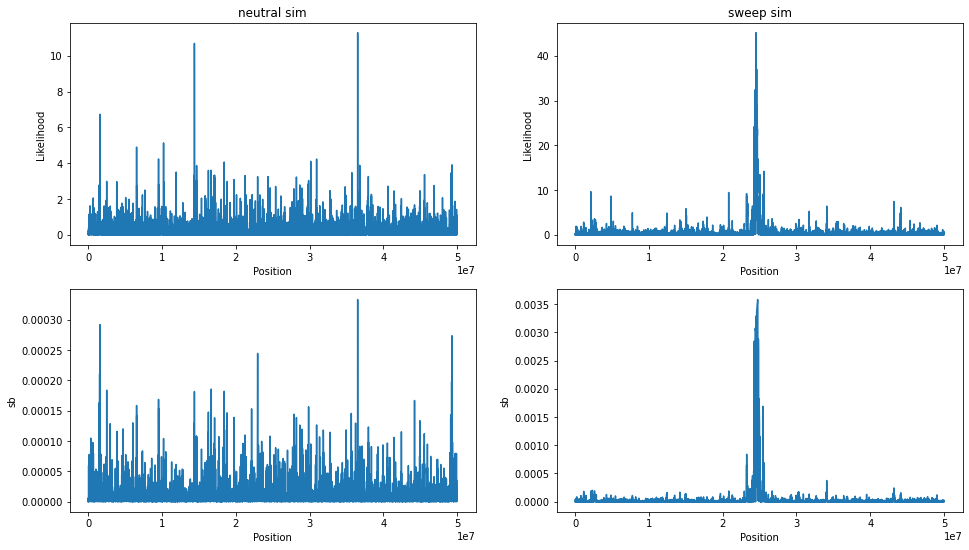

In [39]:
fig,axs = plt.subplots(2,2,figsize=(16,9))

sns.lineplot(data = neutralScan,x="Position",y="Likelihood",ax=axs[0,0])
sns.lineplot(data = neutralScan,x="Position",y="sb",ax=axs[1,0])

sns.lineplot(data = selScan,x="Position",y="Likelihood",ax=axs[0,1])
sns.lineplot(data = selScan,x="Position",y="sb",ax=axs[1,1])
axs[0,0].set_title("neutral sim")
axs[0,1].set_title("sweep sim")
print("Using the folded SFS")
plt.show()

fig.tight_layout()
plt.show()

<div class="alert alert-block alert-success">    
    <b>Exercise 10:</b> Compare neutral and sweep results: is there a clear signature of positive selection? How does the maximum-likelihood estimate of the location of the beneficial mutation and strength of selection compare to the true values of these parameters?

<b>Hint:</b> The method <code>.idxmax()</code> is a quick way to find the index with the max value of a numpy array. Once you know the index of the dataframe row with the maxcimum likelihood you can inspect the entire row  using <code>selScan.loc[index]</code> (see practial 4).
    </div>

In [40]:
#SOL: there is a strong signal near the center of the chromosome for the selection sims.  
max_index = selScan['Likelihood'].idxmax()
selScan.loc[max_index]
#The max likelihood value is much higher than any seen in the neutral model.
#however, we don't pinpoint the exact location of the beneficial mutation
#and the strength of selection is substantially underestimated, as we see below:

Position      2.450368e+07
Likelihood    4.518021e+01
Alpha         6.189498e-06
sb            3.200094e-03
Name: 4900, dtype: float64

# 5.4 Signatures of selection in _Heliconius_ butterflies


Let's look at a SweepFinder scan on a real data set! We will first import a vcf file containing variation data from several individuals of *Heliconius* butterflies belonging to different closely related species and mimicry races. These data were obtained by mapping WGS Illumina reads against the *Heliconius melpomene* reference genome and are from [(Martin et al 2020)](https://datadryad.org/stash/dataset/doi:10.5061/dryad.sk2pd88).

You will analyze this data set much more closely in practical 6. For simplicity, we focus on chromosome 18 and restrict our analysis to 10 individuals from a single sub-species: _H. melpomene malleti_.

### 5.4.1 Importing and Subsetting the _Heliconius_ data

The cell below imports the variant data from the vcf file and and subsets it using scikit allel.

In [53]:
## import the vcf file retaining the genotype calls, variant positions, and sample names
samples_mal = ['mal.CS1002', 'mal.CS1011', 'mal.CS1815', 'mal.CS21', 'mal.CS22', 'mal.CS24', 'mal.CS586', 'mal.CS594', 'mal.CS604', 'mal.CS615']
gt_key, pos_key, sample_key = 'calldata/GT', 'variants/POS', 'samples'
vcf_f ='p5_data/heli_chrom18.vcf.gz'
helidata = allel.read_vcf(vcf_f, fields=[gt_key, pos_key, sample_key], samples=samples_mal)

As in the last practical, we store the variant positions and the genotypes as separate arrays and turn the genotype array into an array of allele counts:

In [54]:
positions = helidata['variants/POS']
heliGTs = allel.GenotypeArray(helidata['calldata/GT']);

mal_counts = heliGTs.count_alleles()
mal_counts

<AlleleCountsArray shape=(1441823, 3) dtype=int32>
18  0  0
17  1  0
15  3  0
...
20  0  0
12  8  0
10 10  0

<div class="alert alert-block alert-success">    
    <b>Exercise 11:</b>
    The data from this VCF file only contain polymorphic sites, so why does the first entry only have a single allele? Use scikit allel's <code>is_biallelic()</code> function to restrict the counts and position arrays to biallelic sites (see practical 4). Store the new counts and positions as <code>ba_mal_counts</code> and <code>ba_positions</code> (check how many sits are filtered out).
</div>

In [55]:
#SOL
# sites that are polymorphic in the full data set may be monomorphic within our subset of the data.
boolBiallelic = mal_counts.is_biallelic()
ba_mal_counts = mal_counts[boolBiallelic]
ba_positions = positions[boolBiallelic]

<div class="alert alert-block alert-success">    
    <b>Exercise 12:</b>
Use the the     
    <a href="https://scikit-allel.readthedocs.io/en/stable/stats/diversity.html#allel.windowed_diversity"><code>allel.windowed_diversity()</code></a> method (see pratical 4, exercise 8) to plot genetic diversity along the chromosome.
</div>

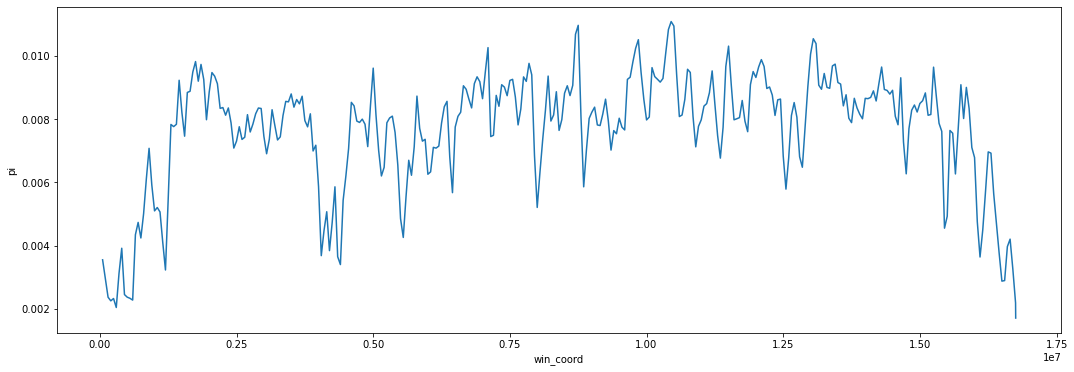

In [56]:
#SOL
window_size = 100_000
pi, windows, bases, counts = allel.windowed_diversity(ba_positions, ba_mal_counts, size=window_size, start=0, stop=ba_positions[-1], step=int(window_size/2))
win_coord = windows[:,1] - (window_size / 2)
win_pi_df = pd.DataFrame({'win_coord':win_coord,'pi':pi})
fig, ax = plt.subplots(figsize=(18,6))
sns.lineplot(x='win_coord', y='pi', data = win_pi_df)
plt.show()

### 5.4.4 Identifying the signatures of selective sweeps

We pre-baked SweepFinder scan results for chromosome 18. 

**Note:** If you want to know how the Heliconius data for chrom 18 were formatted for SweepFinder, the code is in the Appendix. SweepFinder was run using the following command: 
    
<code>../SweeD_v3.2.1_Linux/SweeD -folded -name scanChr18 -input folded_mut_counts_file.txt -grid 10000 -isfs folded_sfs_file.txt</code>

Evaluate the following cell to import the scan results:

In [57]:
scanChr18= pd.read_csv("p5_data/SweeD_Report.scanChr18",header=1,delimiter="\t")

The smallest Alpha values correspond to the highest strength of selection estimated. It is easier to interperet this by plotting  _-log10(Alpha)_ instead, so that we can see selection estimates that range over orders of magnitude and it places the highest estimates of selection strength at the top of the graph.

In [58]:
scanChr18["-log10Alpha"]=scanChr18['Alpha'].apply(lambda x: -math.log10(x))

<div class="alert alert-block alert-success">    
    <b>Exercise 13:</b>
<ul>
    <li>Look at the column names of the scanChr18 dataframe.</li>
    <li>Generate separate lineplots for the sweep likelihood and -log10Alpha along the chromosome.</li>
    <li>Is there any evidence for sweeps on chromosome 18?</li>
    <li>How strongly reduced is genetic diversity in regions containing sweep signals?<l/i>
    </ul>
</div>

NameError: name 'quantile95_fst' is not defined

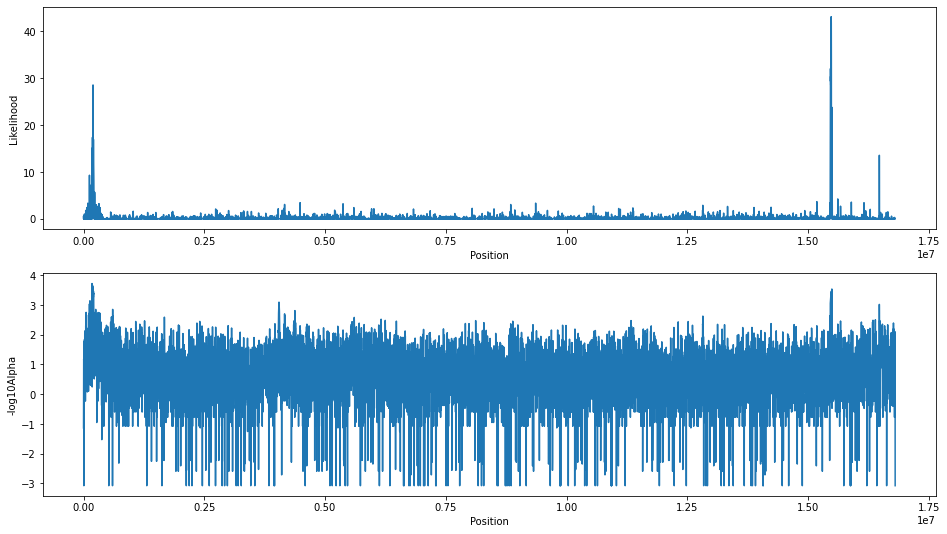

In [59]:
fig,axs = plt.subplots(2,1,figsize=(16,9))

sns.lineplot(data = scanChr18,x="Position",y="Likelihood",ax=axs[0])
sns.lineplot(data = scanChr18,x="Position",y="-log10Alpha",ax=axs[1])
optix_pos = np.array([1058778, 1159581])
plt.axhline(y=quantile95_fst, alpha=0.5, color ='r')
fig.tight_layout()

plt.show()

## Appendix

### Processing Heliconius data for SweepFinder

Since we are using the folded SFS, we only need to know the major/minor allele frequencies at each site, and we can retain the data at sites polymorphic for two alternate alleles. The <code>getMajorMinor(countArr)</code>function below does the trick and calculates the major and minor allele counts.

In [60]:
def getMajorMinor(countArr):#countArr is the list of allele counts [a0,a1,a2] for some position
    maxCount = max(countArr)
    totalCount = sum(countArr)
    minorCount = totalCount - maxCount
    
    return([maxCount,minorCount])

Using the `getMajorMinor` and  numpy's `apply_along_axis` functions, we can get the major and minor allele counts for each biallelic position, storing this as `ba_maj_min`

In [61]:
# get [major,minor] count for the corresponding biallelic positions
ba_maj_min = np.apply_along_axis(getMajorMinor,1,ba_mal_counts)

print(ba_maj_min)

[[17  1]
 [15  3]
 [17  1]
 ...
 [13  7]
 [12  8]
 [10 10]]


We can use <code>ba_positions</code> and <code>ba_maj_min</code>to create a properly-formated dataframe to use as input for SweepFinder (see simulation scans above for formatting).

In [63]:
ba_positions

array([     324,      330,      354, ..., 16802329, 16802398, 16802409],
      dtype=int32)

In [64]:
biallelMutCounts = np.array([[pos,ac[0],sum(ac),1] for pos,ac in list(zip(ba_positions,ba_maj_min))])
biallelMutCounts = pd.DataFrame(biallelMutCounts,columns=['pos','x','n','folded'])
biallelMutCounts

,pos,x,n,folded
0,324,17,18,1
1,330,15,18,1
2,354,17,18,1
3,355,15,18,1
4,361,15,18,1
...,...,...,...,...
482498,16802302,19,20,1
482499,16802315,13,20,1
482500,16802329,13,20,1
482501,16802398,12,20,1


### Empirical SFS for sweep scan input

We used a standard neutral coalescent model in our simulations, and we have analytic expressions for the background SFS under that model. For real data, SweepFinder uses the emperical site frequency spectrum in order to account for the demographic history of the population. Execute the cell below to calculate the empirical folded site frequency spectrum, "foldedSFS" for our butterfly dataset.

In [65]:
coverage = np.apply_along_axis(sum, 1, ba_maj_min)
fullCoverIdx = coverage==nMax
fullCover_ba_maj_min = ba_maj_min[fullCoverIdx]

print(fullCover_ba_maj_min[0:5])

foldedSFS = allel.sfs_folded(fullCover_ba_maj_min)
foldedSFS = foldedSFS/sum(foldedSFS)

print(foldedSFS)

NameError: name 'nMax' is not defined

We filter to obtain only sites that are covered for all individuals in the sample. We need this to calculate the full SFS. Note that we still use partially-covered sites in the analysis because we can calculate the n<nMax SFS by subsampling (see Nielsen 2005).